# Sub Basin Delineation

This notebook demonstrates the workflow for extracting the subbasins of a DEM.
The subbasins are the catchments unique to each segment in the river network.
We can then delineate the valley bottoms, and from the valley bottom polygons get centerlines and then segment that by reach.
Otherwise can use the watershed function (get pour points along unique stream segment in catchment and run watershed function)

This workflow uses streams extracted from the DEM to avoid issues with mismatch between flowlines and topography. 

Both WhiteBoxTools (subbasins) and GrassGIS (r.watershed) can perform subbasin extraction. 

In [1]:
import os
import glob
import shutil

import rioxarray
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from valleys.utils import setup_wbt, quick_plot
from valleys.subbasins import delineate_streams, delineate_subbasins
from valleys.catchment import get_catchment_data

In [2]:
wbt = setup_wbt("~/opt/WBT/", "../data/wb_outputs/")

In [3]:
# setup and load data
dem_file = os.path.abspath('../toy_data/dem_3m.tif')

In [4]:
threshold = 30000
streams_ras_file = delineate_streams(wbt, dem_file, threshold)
streams_ras_file

'/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams.tif'

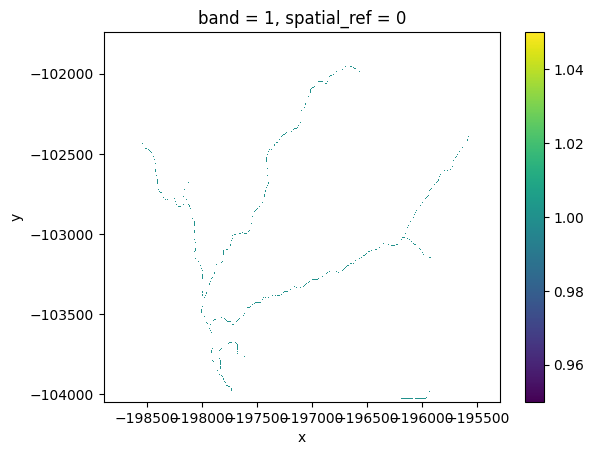

In [5]:
quick_plot(streams_ras_file)

In [6]:
subbasins_res = delineate_subbasins(wbt, dem_file, streams_ras_file)
subbasins_res

{'dem': '/Users/arthurkoehl/programs/pasternack/valleys/toy_data/dem_3m.tif',
 'filled_dem': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/filled_dem.tif',
 'd8_pntr': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/d8_pntr.tif',
 'subbasins': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/subbasins.tif',
 'streams': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams.tif'}

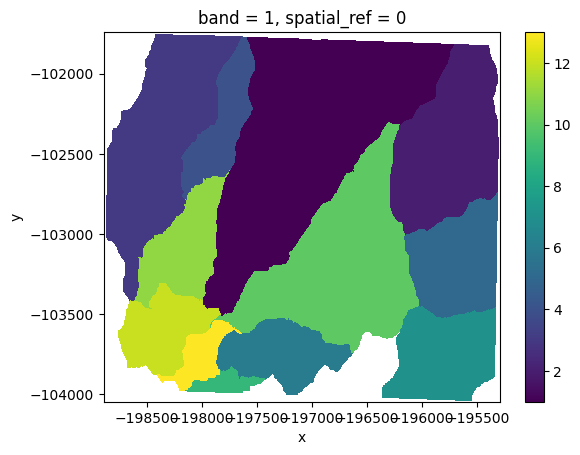

In [7]:
quick_plot(subbasins_res['subbasins'])

In [8]:
dem = rioxarray.open_rasterio(subbasins_res['filled_dem'])
subbasins = rioxarray.open_rasterio(subbasins_res['subbasins'])
streams = rioxarray.open_rasterio(subbasins_res['streams'])
d8_pntr = rioxarray.open_rasterio(subbasins_res['d8_pntr'])

In [9]:
# save to toy_data
dem.rio.to_raster("../toy_data/filled_dem.tif")
subbasins.rio.to_raster("../toy_data/subbasins.tif")
streams.rio.to_raster("../toy_data/streams.tif")
d8_pntr.rio.to_raster("../toy_data/d8_pntr.tif")

# Catchment

In [10]:
catchment_data = get_catchment_data(wbt, subbasins_res['filled_dem'], subbasins_res['subbasins'], 
                                    subbasins_res['streams'], subbasins_res['d8_pntr'], 11)

In [11]:
catchment_data

{'hand': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_hand.tif',
 'streamline': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_streamline.shp',
 'profile_curvature': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_profile_curvature.tif',
 'basin_id': 11,
 'dem': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_dem.tif',
 'streams': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_stream.tif',
 'd8_pntr': '/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/11_d8_pntr.tif'}

In [12]:
for k,file in catchment_data.items():
    if k == 'basin_id':
        continue
    # copy to toy_data
    base_name = os.path.basename(file)
    dest_dir = "../toy_data/"
    # if .shp
    if base_name[-4:] == ".shp":
        files = glob.glob(f"{file[:-4]}.*")
        for f in files:
            shutil.copyfile(f, os.path.join(dest_dir, os.path.basename(f)))
    else:
            shutil.copyfile(file, os.path.join(dest_dir, base_name))